# Segment Anything Model (SAM) Applied to MRI

Author: Evan Hann

Date Created: 7th July 2023

Date Modified: 10th September 2023

# SAM zero-shot segmentation on a cardiac image

![feature_image](images/featuredImage.png)

This notebook demonstrates how to apply Segment Anything Model (SAM) in medical image analysis. Developed by Meta AI Research, SAM was trained on an enormous dataset of 11 million images of everyday objects and scenes to predict high-quality segmentation masks. While SAM was not trained on medical images, its zero-shot capability can be utilized for medical imaging applications, potentially mitigating data scarcity problems faced by many medical practitioners and researchers. In this notebook, we will learn how to load a pretrained SAM, read and preprocess a DICOM image, predict a segmentation mask, and evaluate the segmentation.

In [1]:
from segment_anything import sam_model_registry, SamPredictor
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# The Sunnybrook Cardiac Data
In this notebook, a 2D short-axis view cine frame is selected from the Sunnybrook Cardiac Data (SCD), which consist of MRI scans of the heart from anonymized patients with a mix of pathologies. The complete dataset can be downloaded from <a href="https://www.cardiacatlas.org/sunnybrook-cardiac-data/">here</a>. The image analysis task is to delineate the left ventricular endocardium and epicardium. By placing contours on a series of cine MRI images, we can derive clinical parameters such as ejection fraction which indicate health status of the heart. 

The image is stored as a DICOM file, which is a standard digital image format commonly used in healthcare and biomedical practices. We can use pydicom to extract the image from the DICOM file.

In [2]:
def load_dicom_image(dcm_file_path):
    ds = pydicom.dcmread(dcm_file_path)
    image = ds.pixel_array
    return image

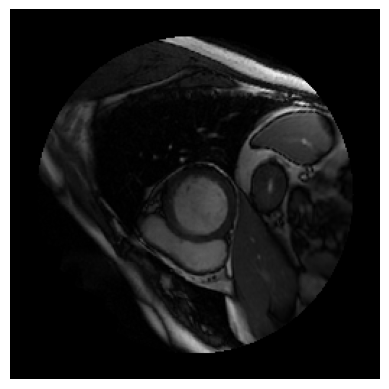

In [3]:
dcm_file_path = "../demo_data/scd-image.dcm"
image = load_dicom_image(dcm_file_path)
original_image_shape = image.shape
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

# Preprocessing

Unlike everyday color images, cardiac MRI cine is usually in gray scale, without color (RGB) channels. In this case, we artificially add RGB channels to the medical image to make the image compatible with SAM, which is designed to handle everyday color images. This can be done by stacking copies of the same medical image together.

Another issue is that SAM supports uint8 pixel dtype but not uint16 (used in the medical image). Simply doing ```image = image.astype("uint8")``` could severely affect the image quality. We need to linearly rescale the image intensity to 0-255 range. 

In addition, image cropping can influence segmentation prediction by SAM. In this notebook, the image is cropped to 150 by 150 pixels around the heart.

One more thing - the image is rotated 90 degrees clockwise so that the right ventricle is on the <i>right</i> side!

In [4]:
def preprocess_image(image, to_rgb=True, to_uint8=True, rot90=True):
    # Add RGB channels
    if to_rgb:
        image = np.stack((image, image, image), axis=-1)
    
    # Convert image from uint16 to uint8
    if to_uint8:
        _min, _max = np.min(image), np.max(image)
        image = (image - _min)/(_max - _min)*255
        image = image.astype("uint8")
    
    # Rotate 90 degrees clockwise
    if rot90:
        image = np.rot90(image, k=3)
    
    return image

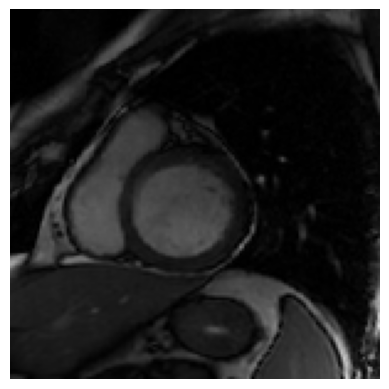

In [5]:
image = preprocess_image(image)
image = image[50:200, 50:200, :]
plt.imshow(image)
plt.axis("off")
plt.show()

# Load a pretrained SAM model

We download a SAM checkpoint from <a href="https://github.com/facebookresearch/segment-anything#model-checkpoints">the SAM repo</a> and assign the downloaded .pth file path to ```sam_checkpoint```. Don't forget to also set the correct ```model_type``` and ```device```.

In [6]:
sam_checkpoint = "../../sam_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Set image and seed points

```set_image(image)``` lets us specify which image to analyze. We supply a seed point (labeled ```1``` to indicate foreground) at position ```(80,80)``` in the endocardium. The seed point is shown as a 5-pointed star in the figure below. 

Although only one seed point is used in this demo, it is possible to supply multiple seed points to potentially improve prediction accuracy. It is also okay not to input any seed point.


In [7]:
predictor.set_image(image)
input_point = np.array([[70, 80]])
input_label = np.array([1])

In [8]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker='*', s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker='*', s=marker_size, edgecolor="white", linewidth=1.25)

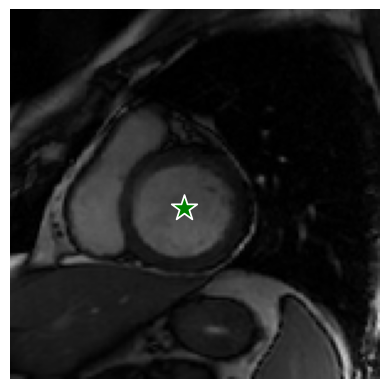

In [9]:
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

# SAM predictions

By calling ```predictor.predict(...)```, SAM outputs binarized segmention masks, confidence scores, and unthresholded mask logits. As ```multimask_output``` option is set to ```True```, SAM generates 3 different segmentations (namely Mask 1, Mask 2, and Mask 3). These segmentation masks are illustrated as blue-color masks overlaid onto the input image.

The results look promising - SAM is able to delineate the left ventricular endocardium with a high confidence score (0.968) as shown in Mask 1. SAM is also able to segment the epicardium (Mask 2). Mask 3 looks like an attempt to segment both the left and the right ventricles with oversegmentation into nearby structures. 

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [11]:
def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

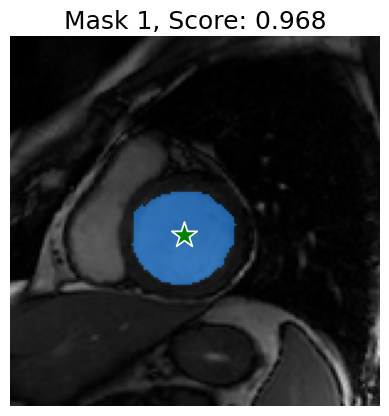

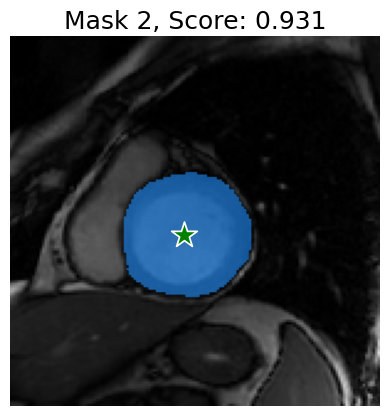

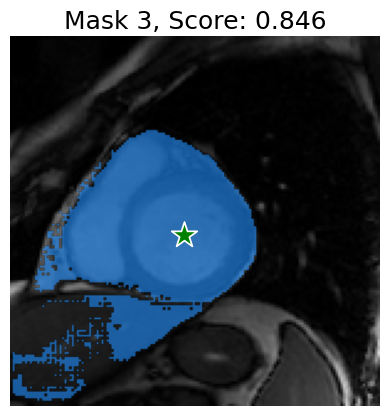

In [12]:
mask_color = np.array([.12, .56, 1., 0.6])

for i in range(3):
    plt.imshow(image)
    show_mask(masks[i,:,:], plt.gca(), mask_color)
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {scores[i]:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

# Evaluation

## Load SCD segmentation mask

The Sunnybrook Cardiac Data (SCD) provides expertly-annotated contours, which will be used to evaluate the SAM-predicted segmentation masks. As these contours are stored as coordinate points, we will covert them to binary masks via ```cv2.fillPloy(...)```. The same preprocessing and cropping steps will be performed to ensure the segmentation masks are in alignment with the images.

In [13]:
import cv2

def load_scd_segmentation_mask(contour_file_path, image_shape):
    # Load contour points
    contour_points = np.loadtxt(contour_file_path, delimiter=" ").astype(int)
    
    # Turn contour points to mask
    mask = np.zeros(image_shape, dtype="uint8")
    cv2.fillPoly(mask, [contour_points], 1)
    
    return mask

In [14]:
icontour_file_path = "../demo_data/scd-icontour-manual.txt"
icontour_mask = load_scd_segmentation_mask(icontour_file_path, original_image_shape)

# Apply the same preprocessing steps
icontour_mask = preprocess_image(icontour_mask, to_rgb=False, to_uint8=False)
icontour_mask = icontour_mask[50:200, 50:200]

In [15]:
ocontour_file_path = "../demo_data/scd-ocontour-manual.txt"
ocontour_mask = load_scd_segmentation_mask(ocontour_file_path, original_image_shape)

# Apply the same preprocessing steps
ocontour_mask = preprocess_image(ocontour_mask, to_rgb=False, to_uint8=False)
ocontour_mask = ocontour_mask[50:200, 50:200]

## Dice similarity coefficient

We use Dice similarity coefficient (DSC) to quantitatively evaluate the SAM-predicted masks against the SCD masks. DSC is a score from 0 to 1 measuring agreement between two masks. A higher DSC score means better agreement (0 indicates no overlap; 1 indicates perfect agreement).

In [16]:
from scipy.spatial.distance import dice as dice_dissimilarity

def dice_similarity(mask1, mask2):
    return 1 - dice_dissimilarity(mask1.flatten(), mask2.flatten())

In [17]:
icontour_dsc = dice_similarity(icontour_mask, masks[0,:,:])
ocontour_dsc = dice_similarity(ocontour_mask, masks[1,:,:])

print(f"DSC for endocardium segmentation: {icontour_dsc:.3f}")
print(f"DSC for epicardium segmentation: {ocontour_dsc:.3f}")

DSC for endocardium segmentation: 0.937
DSC for epicardium segmentation: 0.945


The SAM-predicted masks achieved high DSC scores of 0.937 for the endocardium and 0.945 for the epicardium. Hooray!

While these numbers look promising, it is important to keep in mind that this is only one sample. For the purpose of demo, it is doing its job. For future work, more samples are needed to establish whether SAM's segmentation performance generalizes to a wide range of cases.

## Visual inspection

For qualitative evaluation, we will inspect how the SAM-predicted masks compare to the SCD masks by overlaying them onto the input image. The SAM-predicted segmentations are shown as blue-color masks and the SCD masks are represented as red-color contours.

By visually inspecting the segmentations, we can observe an overall high agreement between the SAM-predicted masks and the SCD masks. However, there is potentially a minor issue of undersegmentation at the inferior wall for both the endocardium and the epicardium masks.

In [18]:
from scipy.ndimage import binary_erosion

def show_contour_from_mask(mask, ax, color):
    contour = mask - binary_erosion(mask)

    h, w = contour.shape[-2:]
    contour_image = contour.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(contour_image)

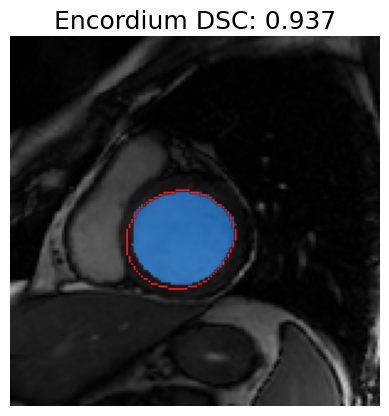

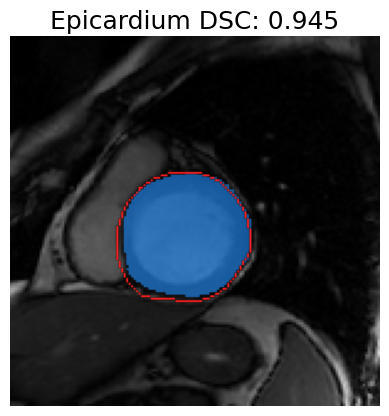

In [19]:
contour_color = np.array([1., .12, .12, 1.])

plt.imshow(image)
show_mask(masks[0,:,:], plt.gca(), mask_color)
show_contour_from_mask(icontour_mask, plt.gca(), contour_color)
plt.title(f"Encordium DSC: {icontour_dsc:.3f}", fontsize=18)
plt.axis("off")
plt.show()

plt.imshow(image)
show_mask(masks[1,:,:], plt.gca(), mask_color)
show_contour_from_mask(ocontour_mask, plt.gca(), contour_color)
plt.title(f"Epicardium DSC: {ocontour_dsc:.3f}", fontsize=18)
plt.axis("off")
plt.show()

# Further Work: Fine-Tuning SAM to Segment Only the Endocardium

In the previous sections, we set ```multiple_output``` to ```True``` for SAM to predict 3 segmentation masks. Alternatively, we can set ```multiple_output``` to ```False``` to generate a single segmentation mask instead. This is useful for applications where we are interested in only a single region (e.g. the endocardium). However, SAM may not know which region to segment especially if an input seed point is ambiguous - a seed point in the center of the left ventricle is valid for both the endocardium and the epicardium. It is possible for SAM to output the epicardium mask (as shown in the figure below) even if we are actually interested in the endocardium. In this case, we need to retrain SAM with additional endocardium segmentation data. In the next notebook, we will explore how to perform the retraining to fine-tune SAM for specific applications.

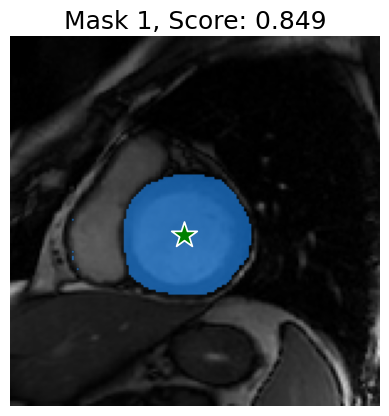

In [20]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False, # set to False to output a single segmentation mask
)

for i in range(1):
    plt.imshow(image)
    show_mask(masks[i,:,:], plt.gca(), mask_color)
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {scores[i]:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

# Conclusion

In this notebook, we have learned how to apply a Segment-Anything Model (SAM), pretrained on everyday images, to analyze a medical image. With excellent zero-shot capability, SAM successfully delinated the endocardium and the epicardium with an overall high agreement comparing to the expertly-annotated masks. SAM achieved promising performance with high DSC scores above 0.93. The visual inspection confirmed the overall good quality of the predicted masks and identified a minor issue of undersegmentation. There is enormous potential to utilize large-scale pretrained models such as SAM to mitigate data scarcity problems in various medical applications. For future work, it is important to evaluate SAM on a large-scale test dataset to establish whether the segmentation performance generalizes to a wide range of samples.

# Acknowledgement
Some of the code in this notebook was adapted from the <a href="https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">predictor_example</a> notebook.

